In [ ]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Select

The `SELECT` operation, defined by $$ SELECT \left( | i \rangle \otimes | \psi \rangle \right) = |i \rangle \otimes U_i | \psi \rangle $$ is a fundamental primitive in quantum computing. In recent years techniques such as Quantum Singular Value Transformations (QSVT) have brought about a unifying way to construct virtually all known quantum algorithms. Qualtran has a few different techniques for implementing these oracles; this article aims to explain how the basic construction underlying a few of the implementations, known as Unary Iteration, is done. Towards the end, variants such as SELECT-SWAP or QROAM, as well as pointers to specific implementations for physical systems such as chemical systems or Hubbard Models are mentioned. 

## Unary Iteration

Throughout the following discussion we will use the universal gate set of Clifford + T gates, with the goal of minimizing the number of T gates (and therefore Toffoli gates). We also assume that the user has a control register `ctrl` that contains the state to be "selected on" and a system register `sys` that the target unitaries are applied to. We will be very pedagogical and start off with a two qubit `ctrl` register (a 1 qubit `ctrl` is just a controlled version of your bloq), show how to add in additional register, and lastly explain how to move to an arbitrary `ctrl` register using segment trees. Throughout we will demonstrate how to build these bloqs from scratch using Qualtran, so lets import the necessary code now.

In [1]:
import math
import numpy as np
from qualtran import BloqBuilder, QUInt, QAny, QBit, Bloq, Signature, CompositeBloq, Soquet
from qualtran.bloqs.basic_gates.rotation import CZPowGate
from qualtran.bloqs.basic_gates.cnot import CNOT
from qualtran.bloqs.mcmt.and_bloq import And
from qualtran.bloqs.basic_gates.toffoli import Toffoli
from qualtran.bloqs.basic_gates.x_basis import XGate
from qualtran.bloqs.basic_gates.identity import Identity
from qualtran.drawing.musical_score import draw_musical_score, get_musical_score_data
from qualtran.drawing import get_musical_score_data, draw_musical_score
import attrs
from typing import Dict, List
from qualtran import BloqBuilder, Register
from qualtran._infra.composite_bloq import SoquetT


def int_to_bool_list(num, bitsize):
    """converts a given `num` as an integer to a list of booleans in big endian
     Ex: `assert int_to_bool_list(11, 4) == [True, False, True, True]` """
    x = [bool(num & (1<<n)) for n in range(bitsize)]
    x.reverse()
    return x

As a warmup we will first demonstrate how to do unary iteration with only 2 `ctrl` qubits, meaning we have four nontrivial unitaries $U_0, \ldots, U_3$ that we would like to apply to `sys` based on the state of `ctrl`. Given that we only have access to single qubit controlled unitaries, we will have to iterate through through these unitaries and determine whether or not the `ctrl` register is in the proper state in a single ancilla qubit, which we call `anc`. We can do this pretty straightforwardly using just Toffoli and X gates. The first half is to flip the `ctrl` qubits (0 -> 1 and 1 -> 0) using X, store the Toffoli of these two into `anc` so that `anc = ~ctrl[0] * ~ctrl[1]`, meaning `anc = 1` if and only if both `ctrl` qubits start out in the 0 state. After this we do our controlled $U_0$, which we will use a controlled Z rotation with the index as the rotation angle for demonstration purposes, and then uncompute. The Qualtran code for this is

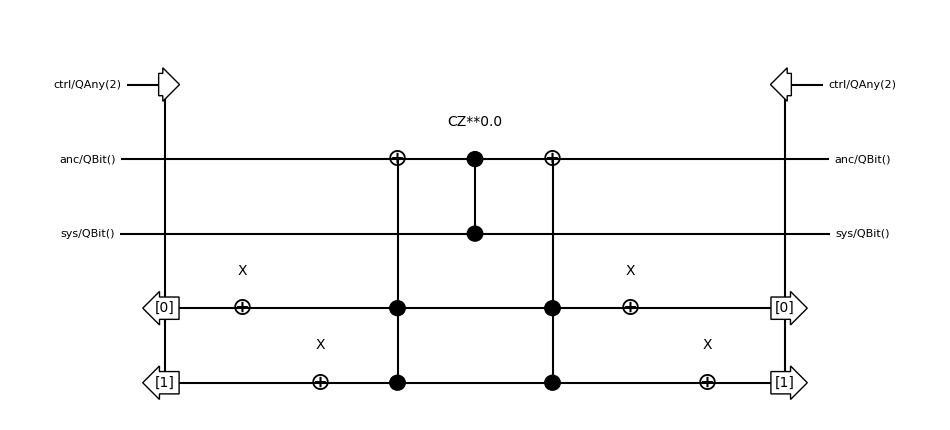

In [2]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now that we have the 0 state taken care of, we can repeat this process for the remaining states 1, 2, and 3. The insight is that the X patterns dictate which state is "selected" on.

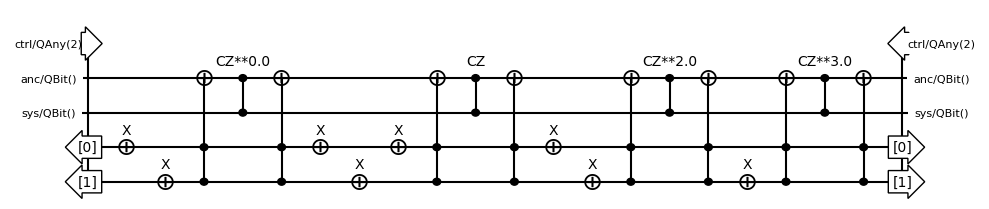

In [3]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

# SELECT on 0 = 00
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 1 = 01
ctrls[0] = bb.add(XGate(), q=ctrls[0])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=1.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])

# SELECT on 2 = 10
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=2.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 3 = 11
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=3.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now the above cirquit is correct (TODO: Should we add in testing?), but there is a lot of redundancy. For example, the two X gates done back to back on the `ctrls[0]` register can be cancelled. The second gate saving we could do is based on the identity that an X gate between two Toffoli's can be replaced with the same X gate and a CNot on the other control
$$
Toffoli \cdot I \otimes X \otimes I \cdot Toffoli = CNOT(1, 3) \cdot I \otimes X \otimes I.
$$
Implementing these reductions gives the final unary iteration bloq for 0,...,3 as

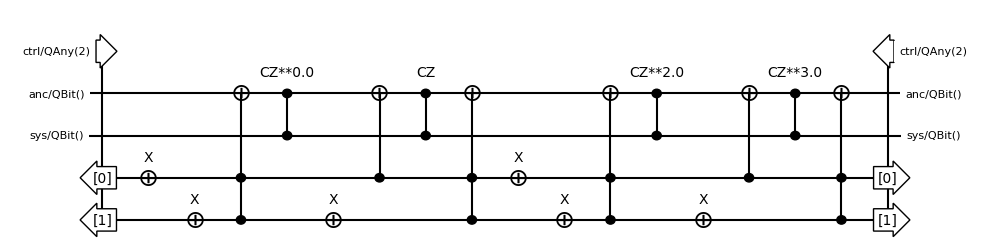

In [5]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

# SELECT on 0 = 0b00
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 1 = 0b01

ctrls[0], anc = bb.add(CNOT(), ctrl=ctrls[0], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=1.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])

# SELECT on 2 = 0b10
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=2.0), q=[anc, sys])

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 3 = 0b11
ctrls[0], anc = bb.add(CNOT(), ctrl=ctrls[0], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=3.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now from these simplifications it is pretty clear that there are two groups of operations going on, the $U_0$ and $U_1$ half and the $U_2, U_3$ half. Since there are no more simplifications to make, we can now proceed to analyze what exactly the circuit is doing at each step, with the intent to generalize to larger control registers. The way we will go about this is by tracking the state of the ancilla qubit right before each CZ. We will do so using boolean algebra, if $x$ and $y$ are variables then $\bar{x}$ denotes the logical NOT of $x$, $x \oplus y$ the XOR operation, and $x \otimes y$ the AND operation. We also use $c_0$ and $c_1$ to denote the state of the `ctrl` qubits 0 and 1 respectively.

Before CZ**0.0, the state of the ancilla is just the output of the Toffoli, which is 
$$|\bar{c_0} \otimes \bar{c_1} \rangle.$$ 

Now to get to the state before `CZ**1.0` we just have to do a CNOT with the control in the state $\bar{c_0}$. This results in
$$ |\bar{c_0} \otimes \bar{c_1} \oplus \bar{c_0} \rangle = |\bar{c_0} \otimes (\bar{c_1} \oplus 1) \rangle = |\bar{c_0} \otimes c_1 \rangle.$$ 
This is clearly only 1 if the control register is in 01 as we wanted.

To get to the next `CZ` we have to perform two Toffoli gates. Instead of doing one after the other we can add into the ancilla the net result of both of them. As one Toffoli has the effect of adding in the logical multiplication of the two controls, the net effect of the two Toffoli's between `CZ**1.0` and `CZ**2.0` is to add in $\bar{c_0} \otimes c_1 \oplus c_0 \otimes \bar{c_1}$. Adding this into the ancilla state from the previous expression gives us
$$ |\bar{c_0} \otimes c_1 \oplus \bar{c_0} \otimes c_1 \oplus c_0 \otimes \bar{c_1} \rangle = |c_0 \otimes \bar{c_1} \rangle $$

By now it should be clear what the next state will be, the CNOT added into this last state gives us
$$ |c_0 \otimes \bar{c_1} \oplus c_0 \rangle = |c_0 \otimes (\bar{c_1} \oplus 1) \rangle = |c_0 \otimes c_1\rangle, $$
as it should. 

## Beyond 2 Control Qubits with Segment Trees

Now that we know the ins and outs of how the 2 qubit Unary Iteration works it is clear that if we wanted to do an arbitrary controlled qubit we could just extend this process: Compute the $n$-qubit AND of the `ctrl` qubits, using `n-1` ancillas, uncompute, and then flip the `ctrl` qubits to change which qubit we are selecting on. After this circuit is laid out, we can go back and perform cancellations to reduce the number of gates significantly. Although this would work, adding gates just to cancel them later is rather inefficient and it would be better if we could introduce structure which would get the correct gates from the start. The abstraction we will use which lets us do this is called a Segment Tree, or an interval tree, which we will develop a small example of now.

A [Segment Tree](https://en.wikipedia.org/wiki/Segment_tree) is a way of organizing a collection of intervals (of the real line) in a binary tree structure that allows us to ask which intervals a given number falls in. The intervals we will use are single number intervals $[i, i+1)$ ranging over the possible values we would like to query `ctrl` for. Before we jump in and build a unary iterator for quantum registers, to illustrate how the datastructure works we will build one for classical bits. We are going to build this in a class `SegmentTree` in two stages: first we will implement the computation stage and second the uncomputation stage. 

In order for us to be able to query a `ctrl` register we need to store where our "iterator" is in the binary tree. This will be done using a `state`, which is a list of `True` and `False`. Think of this list of `True` or `False` as giving the position of a walker on a binary tree. If the walker always starts out at the root node, then `state[0]` will tell us if the walker should traverse the left half (`state[0] == False`) or the right half (`state[0] == True`) of the tree. By repeating this process an $n$ bit state vector will give us the position of a depth $n$ tree. Now the key point is that we can store information about the `ctrl` register while performing this navigation so that by the time we reach the bottom of the tree we then know if the `ctrl` register is in the same state as the walker or if the two are different. This information we store in ancilla bits, or `anc` for short. The invariant that we want to store is that `anc[i] = (ctrl[i + 1] == state[i + 1]) and anc[i - 1]`, and in order to break the recursion we use the convention that `anc[-1] = ctrl[0] == state[0]`. 

In [17]:
class SegmentTree():
    ctrl_bitsize: int
    def __init__(self, ctrl_bitsize: int, ops):
        """A segment tree with unit intervals that can iterate through all possible configurations of ctrl bits.
        """
        # We need ctrl_bitsize - 1 ancillas, initialize them to 0
        self.state = []
        self.ancilla_bits = [False for ix in range(ctrl_bitsize - 1)]
        self.ctrl_bitsize = int(ctrl_bitsize)
        self.ops = ops

    def compute(self, query, ctrl):
        for ix in range(len(self.state)):
            assert self.state[ix] == query[ix]
        if len(self.state) == len(query):
            return
        if len(self.state) == 0:
            self.ancilla_bits[0] ^= (ctrl[0] == query[0]) and (ctrl[1] == query[1])
            self.state.append(query[0])
            self.state.append(query[1])
        else:
            ctrl_ix = len(self.state)
            self.ancilla_bits[ctrl_ix - 1] ^= self.ancilla_bits[ctrl_ix - 2] and (ctrl[ctrl_ix] == query[ctrl_ix])
            self.state.append(query[ctrl_ix])
        self.compute(query, ctrl)

    def select(self, query, ctrl):
        query_list = int_to_bool_list(query, self.ctrl_bitsize)
        self.compute(query_list, ctrl)
        if self.ancilla_bits[-1]:
            print(self.ops[query])

ops = {0: "zero", 1: "one", 2: "two", 5: "five"}
st = SegmentTree(3, ops)
ctrl = int_to_bool_list(5, 3)
st.select(5, ctrl)
st = SegmentTree(3, ops)
st.select(2, ctrl)

five


So far the computing works, it correctly identifies when `ctrl` is in the same state as the given query. One major issue though is we can only use the object once, because otherwise the invariant for `compute` of `state` being a prefix of `query` is not met. To fix this we need to introduce `uncompute`, which walks *up* the binary segment tree so that `compute` can walk down. 

In [4]:
class SegmentTree():
    ctrl_bitsize: int
    def __init__(self, ctrl, ops):
        """A segment tree with unit intervals that can iterate through all possible configurations of ctrl bits.
        """
        # We need ctrl_bitsize - 1 ancillas, initialize them to 0
        self.state = []
        self.ctrl_bitsize = math.ceil(np.log2(ctrl))
        self.ctrl = int_to_bool_list(ctrl, self.ctrl_bitsize)
        self.ancilla_bits = [False for ix in range(self.ctrl_bitsize - 1)]
        self.ops = ops

    def compute(self, query):
        for ix in range(len(self.state)):
            assert self.state[ix] == query[ix]
        if len(self.state) == len(query):
            return
        if len(self.state) == 0:
            self.ancilla_bits[0] ^= (self.ctrl[0] == query[0]) and (self.ctrl[1] == query[1])
            self.state.append(query[0])
            self.state.append(query[1])
        else:
            ctrl_ix = len(self.state)
            self.ancilla_bits[ctrl_ix - 1] ^= self.ancilla_bits[ctrl_ix - 2] and (self.ctrl[ctrl_ix] == query[ctrl_ix])
            self.state.append(query[ctrl_ix])
        self.compute(query)
    
    def uncompute(self, query):
        first_diff_ix = None
        for ix in range(len(self.state)):
            if self.state[ix] != query[ix]:
                first_diff_ix = ix
                break
        if first_diff_ix is None:
            # state is a prefix of query so we do not need to uncompute
            return
        if first_diff_ix < len(self.state) - 1:
            # we have some extra bits we have to undo
            if len(self.state) == 2 and first_diff_ix == 0:
                # we are the bottom of the barrel
                self.ancilla_bits[0] ^= (self.ctrl[0] == self.state[0]) and (self.ctrl[1] == self.state[1])
                self.state.pop()
                self.state.pop()
            else:
                self.ancilla_bits[len(self.state) - 2] ^= self.ancilla_bits[len(self.state) - 3] and (self.state[-1] == self.ctrl[len(self.state) - 1])
                self.state.pop()
            self.uncompute(query)
        else:
            # first_diff_ix is the last bit, so we just need to do the CNOT trick
            if first_diff_ix == 1:
                self.ancilla_bits[first_diff_ix - 1] ^= (self.ctrl[0] == self.state[0])
                self.state[1] ^= True
            else:
                self.ancilla_bits[first_diff_ix - 1] ^= self.ancilla_bits[first_diff_ix - 1]
                self.state[first_diff_ix] ^= True
            return

    def select(self, query):
        query_list = int_to_bool_list(query, self.ctrl_bitsize)
        self.uncompute(query_list)
        self.compute(query_list)
        if self.ancilla_bits[-1]:
            print(self.ops[query])
        else:
            print("Miss!")

In [3]:
ops = {0: "Hit: zero", 3: "Hit: three", 5: "Hit: five"}
st = SegmentTree(3, ops)
ctrl = int_to_bool_list(5, 3)
st.select(5)
st.select(3)
st.select(0)

Miss!
three
Miss!


Now that we have all the reversible logic implemented and the iterative queries implemented we can finally move on to using this to build a bloq that acts on **quantum** registers! We now have to be able to query `ctrl` that is a quantum register using ancillas that are also qubits. This will essentially boil down to moving our AND and XOR logic to Toffolis and CNOTs. We start below with the computation step to verify these cirquits work

In [2]:
class UnaryIterator(Bloq):
    ctrl_bitsize: int
    state = []
    sys_bitsize: int
    ops

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QAny(self.ctrl_bitsize)), Register('anc', QAny(self.ctrl_bitsize - 1)), Register('sys', QAny(self.sys_bitsize))])
    
    def set_ops(self, ops):
        self.ops = ops

    def compute(self, query: List[bool], bb: BloqBuilder, ancs, ctrls):
        for ix in range(len(self.state)):
            assert self.state[ix] == query[ix]
        if len(self.state) == len(query):
            return
        if len(self.state) == 0:
            g0 = XGate() if query[0] == False else Identity()
            g1 = XGate() if query[1] == False else Identity()
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            ctrls[:2], ancs[0] = bb.add(Toffoli(), ctrl=ctrls[:2], target=ancs[0])
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            self.state.append(query[0])
            self.state.append(query[1])
        else:
            ctrl_ix = len(self.state)
            g = XGate() if query[ctrl[ix]] == False else Identity()
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            [ctrls[ctrl_ix], ancs[ctrl_ix - 2]], ancs[ctrl_ix - 1] = bb.add(Toffoli(), ctrl=[ctrls[ctrl_ix], ancs[ctrl_ix - 2]], target=ancs[ctrl_ix - 1])
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            self.state.append(query[ctrl_ix])
        self.compute(query, bb, ancs, ctrls)

    def build_composite_bloq(self, bb: BloqBuilder, ctrl: SoquetT, anc: SoquetT, sys: SoquetT) -> Dict[str, 'SoquetT']:
        queries = list(self.ops.keys())
        queries.sort()
        ctrls = bb.split(ctrl)
        ancs = bb.split(anc)
        for q_int in [2]:
            q_bools = int_to_bool_list(q_int, self.ctrl_bitsize)
            self.compute(q_bools, bb, ancs, ctrls)
            print(f"calling ops[{q_int}]")
            [ancs[-1], sys] = bb.add(self.ops[q_int], q=[ancs[-1], sys])
        ctrl = bb.join(ctrls)
        anc = bb.join(ancs)
        return {'ctrl': ctrl, 'sys': sys, 'anc': anc}

cbloq = UnaryIterator()
cbloq.ctrl_bitsize = 3
cbloq.sys_bitsize = 1
ops = dict()
for ix in range(4):
    ops[ix] = CZPowGate(exponent=float(ix))
cbloq.set_ops(ops)
msd = get_musical_score_data(cbloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(18)
fig.set_figheight(7)

NameError: name 'ops' is not defined

Now we just have to translate the uncompute function from classical to quantum

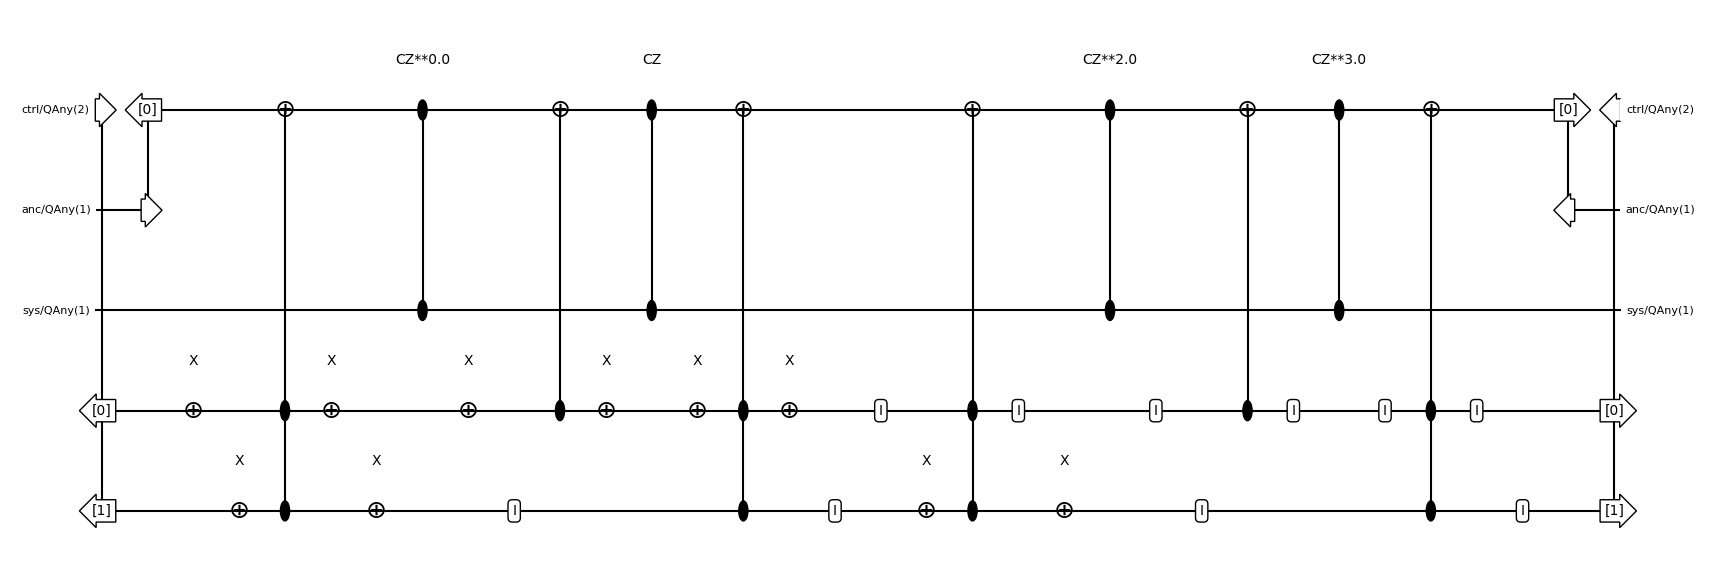

In [11]:
class UnaryIterator(Bloq):
    ctrl_bitsize: int
    state = []
    sys_bitsize: int

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QAny(self.ctrl_bitsize)), Register('anc', QAny(self.ctrl_bitsize - 1)), Register('sys', QAny(self.sys_bitsize))])
    
    def set_ops(self, ops):
        self.ops = ops

    def compute(self, query: List[bool], bb: BloqBuilder, ancs, ctrls):
        for ix in range(len(self.state)):
            assert self.state[ix] == query[ix]
        if len(self.state) == len(query):
            return
        if len(self.state) == 0:
            g0 = XGate() if query[0] == False else Identity()
            g1 = XGate() if query[1] == False else Identity()
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            ctrls[:2], ancs[0] = bb.add(Toffoli(), ctrl=ctrls[:2], target=ancs[0])
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            self.state.append(query[0])
            self.state.append(query[1])
        else:
            ctrl_ix = len(self.state)
            g = XGate() if query[ctrl_ix] == False else Identity()
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            [ctrls[ctrl_ix], ancs[ctrl_ix - 2]], ancs[ctrl_ix - 1] = bb.add(Toffoli(), ctrl=[ctrls[ctrl_ix], ancs[ctrl_ix - 2]], target=ancs[ctrl_ix - 1])
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            self.state.append(query[ctrl_ix])
        self.compute(query, bb, ancs, ctrls)

    def uncompute(self, query: List[bool], bb: BloqBuilder, ancs, ctrls):
        first_diff_ix = None
        if len(query) == 0:
            first_diff_ix = 0
        else: 
            for ix in range(len(self.state)):
                if self.state[ix] != query[ix]:
                    first_diff_ix = ix
                    break
        if first_diff_ix is None:
            # state is a prefix of query so we do not need to uncompute
            return
        if first_diff_ix < len(self.state) - 1:
            # we have some extra bits we have to undo
            if len(self.state) == 2 and first_diff_ix == 0:
                # we are the bottom of the barrel
                g0 = XGate() if self.state[0] == False else Identity()
                g1 = XGate() if self.state[1] == False else Identity()
                ctrls[0] = bb.add(g0, q=ctrls[0])
                ctrls[1] = bb.add(g1, q=ctrls[1])
                ctrls[:2], ancs[0] = bb.add(Toffoli(), ctrl=ctrls[:2], target=ancs[0])
                ctrls[0] = bb.add(g0, q=ctrls[0])
                ctrls[1] = bb.add(g1, q=ctrls[1])
                self.state.pop()
                self.state.pop()
            else:
                ctrl_ix = len(self.state) - 1
                g = XGate() if self.state[ctrl_ix] == False else Identity()
                ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
                [ctrls[ctrl_ix], ancs[ctrl_ix - 2]], ancs[ctrl_ix - 1] = bb.add(Toffoli(), ctrl=[ctrls[ctrl_ix], ancs[ctrl_ix - 2]], target = ancs[ctrl_ix - 1])
                ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
                self.state.pop()
            self.uncompute(query, bb, ancs, ctrls)
        elif len(self.state) == 0:
            return
        else:
            # first_diff_ix is the last bit, so we just need to do the CNOT trick
            if first_diff_ix == 1:
                g = XGate() if self.state[0] == False else Identity()
                ctrls[0] = bb.add(g, q=ctrls[0])
                ctrls[0], ancs[0] = bb.add(CNOT(), ctrl=ctrls[0], target=ancs[0])
                ctrls[0] = bb.add(g, q=ctrls[0])
                self.state[1] ^= True
            else:
                ancs[first_diff_ix - 2], ancs[first_diff_ix - 1] = bb.add(CNOT(), ctrl=ancs[first_diff_ix - 2], target=ancs[first_diff_ix - 1])
                self.state[first_diff_ix] ^= True
            return

    def build_composite_bloq(self, bb: BloqBuilder, ctrl: SoquetT, anc: SoquetT, sys: SoquetT) -> Dict[str, 'SoquetT']:
        queries = list(self.ops.keys())
        queries.sort()
        ctrls = bb.split(ctrl)
        ancs = bb.split(anc)
        for q_int in queries:
            q_bools = int_to_bool_list(q_int, self.ctrl_bitsize)
            self.uncompute(q_bools, bb, ancs, ctrls)
            self.compute(q_bools, bb, ancs, ctrls)
            [ancs[-1], sys] = bb.add(self.ops[q_int], q=[ancs[-1], sys])
        self.uncompute([], bb, ancs, ctrls)
        ctrl = bb.join(ctrls)
        anc = bb.join(ancs)
        return {'ctrl': ctrl, 'sys': sys, 'anc': anc}
    
cbloq = UnaryIterator()
cbloq.ctrl_bitsize = 2
cbloq.sys_bitsize = 1
ops = dict()
for ix in range(4):
    ops[ix] = CZPowGate(exponent=float(ix))
cbloq.set_ops(ops)
msd = get_musical_score_data(cbloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(18)
fig.set_figheight(7)

And we can see that we have replicated almost exactly the hand-crafted circuit from the beginning! The only difference is that we have extra factors of  $X^2$ gates floating around, but since $X^2 = I$ these would be cancelled if we ran a circuit optimizer. The cool thing about this implementation is that now we can replicate more complicated circuits, such as Fig. 7 in [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/pdf/1805.03662) just by changing the bit sizes and operations used. Create a code block below and see what you can make, or if you can eliminate the duplicated Pauil X gates.

# Measurement Based Uncomputation

Now that we have a recursive implementation of a unary iteration cirquit we can further reduce the number of Toffoli gates used by introducing a trick for the `uncompute` step called measurement based uncomputation. The key idea is that instead of using a Toffoli to uncompute an ancilla we can change the bit information of the ancilla into a relative phase, then measure the ancilla and apply a correction phase to the state if needed. We will walk through mathematically how this works, then we will implement a bloq that can act as a measurement and classically controlled operations based on the measurement outcome.

To start with measurement based uncomputation, assume we have three qubits in the state $|a \rangle |b\rangle |0\rangle$ and we apply a Toffoli gate to get $|a\rangle |b\rangle |a \otimes b\rangle$. Now to uncompute we apply a Hadamard gate to the third qubit. If $a \otimes b$ is 0, then the Hadamard will put the third qubit in the state $|0\rangle + |1\rangle$ (up to normalization). If $a \otimes b$ is 1, then we get $|0\rangle - |1\rangle$, so the third qubit is in the state $|0\rangle + (-1)^{a \otimes b} |1\rangle$. After the Hadamard gate we then perform a measurement on the third qubit. If the measurement is 0 then we are good, however if the measurement is 1 then we have to correct for the phase of $(-1)^{a \otimes b}$ that was introduced. This can be easily corrected by performing a CZ gate between $a$ and $b$, which takes 0 T gates to do.

The rest of this notebook will walk through a mock-up of how to implement these ideas in Qualtran, starting with a a `Measure` bloq and followed by the classically controlled logic. We then will put this together in the unary iterator bloq we constructed earlier and see how many T-gates we can save. 

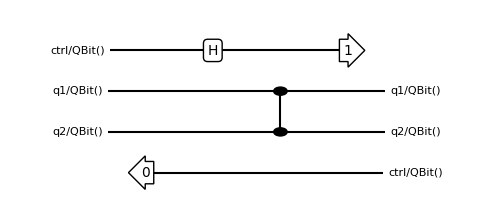

In [4]:
from qualtran import CompositeBloq
from qualtran import Side
from qualtran._infra.bloq import DecomposeTypeError
from qualtran.bloqs.basic_gates.hadamard import Hadamard
from qualtran.bloqs.basic_gates.z_basis import CZ, OneEffect, ZeroEffect, ZeroState

class MeasurementUncomputation(Bloq):
    outcome: None | bool

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QBit()), Register('q1', QBit()), Register('q2', QBit())])
    
    def build_composite_bloq(self, bb: BloqBuilder, ctrl: SoquetT, q1: SoquetT, q2: SoquetT) -> Dict[str, 'SoquetT']:
        ctrl = bb.add(Hadamard(), q=ctrl)
        bb.add(OneEffect(), q=ctrl)
        q1, q2 = bb.add(CZ(), q1=q1, q2=q2)
        ctrl = bb.add(ZeroState())
        return {'ctrl': ctrl, 'q1' : q1, 'q2': q2}
    
meas = MeasurementUncomputation() 
msd = get_musical_score_data(meas.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(5)
fig.set_figheight(2)

In an ideal world we would actually implement a measurement and use the outcome to determine if we perform the CZ gate, but since we are only interested in the worst-case Toffoli/T-gate analysis then always performing the CZ will suffice. Now we replace all the Toffoli's in the `uncompute` function for our `UnaryIterator` bloq below:

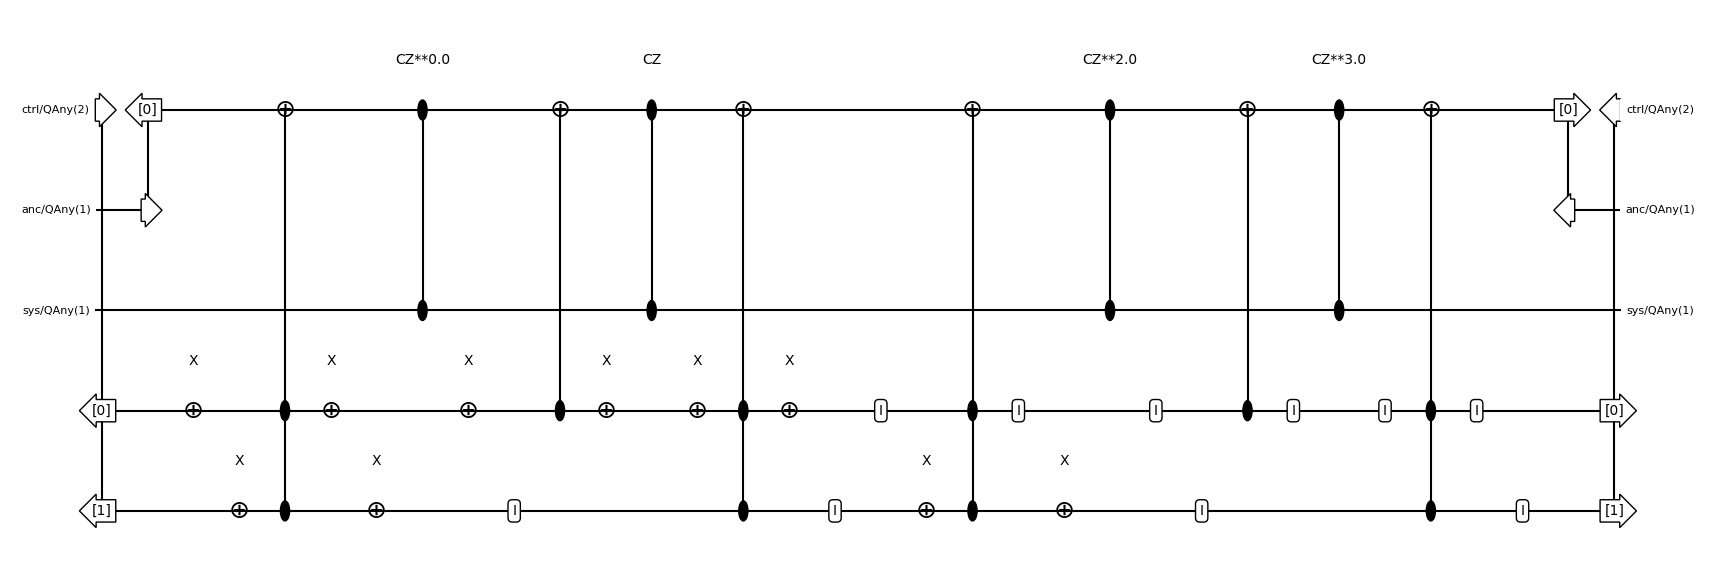

In [13]:
class MBCUnaryIterator(Bloq):
    ctrl_bitsize: int
    state = []
    sys_bitsize: int

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QAny(self.ctrl_bitsize)), Register('anc', QAny(self.ctrl_bitsize - 1)), Register('sys', QAny(self.sys_bitsize))])
    
    def set_ops(self, ops):
        self.ops = ops

    def compute(self, query: List[bool], bb: BloqBuilder, ancs, ctrls):
        for ix in range(len(self.state)):
            assert self.state[ix] == query[ix]
        if len(self.state) == len(query):
            return
        if len(self.state) == 0:
            g0 = XGate() if query[0] == False else Identity()
            g1 = XGate() if query[1] == False else Identity()
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            ctrls[:2], ancs[0] = bb.add(Toffoli(), ctrl=ctrls[:2], target=ancs[0])
            ctrls[0] = bb.add(g0, q=ctrls[0])
            ctrls[1] = bb.add(g1, q=ctrls[1])
            self.state.append(query[0])
            self.state.append(query[1])
        else:
            ctrl_ix = len(self.state)
            g = XGate() if query[ctrl_ix] == False else Identity()
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            [ctrls[ctrl_ix], ancs[ctrl_ix - 2]], ancs[ctrl_ix - 1] = bb.add(Toffoli(), ctrl=[ctrls[ctrl_ix], ancs[ctrl_ix - 2]], target=ancs[ctrl_ix - 1])
            ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
            self.state.append(query[ctrl_ix])
        self.compute(query, bb, ancs, ctrls)

    def uncompute(self, query: List[bool], bb: BloqBuilder, ancs, ctrls):
        first_diff_ix = None
        if len(query) == 0:
            first_diff_ix = 0
        else: 
            for ix in range(len(self.state)):
                if self.state[ix] != query[ix]:
                    first_diff_ix = ix
                    break
        if first_diff_ix is None:
            # state is a prefix of query so we do not need to uncompute
            return
        if first_diff_ix < len(self.state) - 1:
            # we have some extra bits we have to undo
            if len(self.state) == 2 and first_diff_ix == 0:
                # we are the bottom of the barrel
                g0 = XGate() if self.state[0] == False else Identity()
                g1 = XGate() if self.state[1] == False else Identity()
                ctrls[0] = bb.add(g0, q=ctrls[0])
                ctrls[1] = bb.add(g1, q=ctrls[1])
                ancs[0], ctrls[0], ctrls[1] = bb.add(MeasurementUncomputation(), ctrl=ancs[0], q1=ctrls[0], q2=ctrls[1])
                ctrls[0] = bb.add(g0, q=ctrls[0])
                ctrls[1] = bb.add(g1, q=ctrls[1])
                self.state.pop()
                self.state.pop()
            else:
                ctrl_ix = len(self.state) - 1
                g = XGate() if self.state[ctrl_ix] == False else Identity()
                ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
                ancs[ctrl_ix - 1], ctrls[ctrl_ix], ancs[ctrl_ix - 2] = bb.add(MeasurementUncomputation(), ctrl = ancs[ctrl_ix - 1], q1 = ctrls[ctrl_ix], q2 = ancs[ctrl_ix - 2])
                ctrls[ctrl_ix] = bb.add(g, q=ctrls[ctrl_ix])
                self.state.pop()
            self.uncompute(query, bb, ancs, ctrls)
        elif len(self.state) == 0:
            return
        else:
            # first_diff_ix is the last bit, so we just need to do the CNOT trick
            if first_diff_ix == 1:
                g = XGate() if self.state[0] == False else Identity()
                ctrls[0] = bb.add(g, q=ctrls[0])
                ctrls[0], ancs[0] = bb.add(CNOT(), ctrl=ctrls[0], target=ancs[0])
                ctrls[0] = bb.add(g, q=ctrls[0])
                self.state[1] ^= True
            else:
                ancs[first_diff_ix - 2], ancs[first_diff_ix - 1] = bb.add(CNOT(), ctrl=ancs[first_diff_ix - 2], target=ancs[first_diff_ix - 1])
                self.state[first_diff_ix] ^= True
            return

    def build_composite_bloq(self, bb: BloqBuilder, ctrl: SoquetT, anc: SoquetT, sys: SoquetT) -> Dict[str, 'SoquetT']:
        queries = list(self.ops.keys())
        queries.sort()
        ctrls = bb.split(ctrl)
        ancs = bb.split(anc)
        bb.add_register_allowed = True
        for q_int in queries:
            q_bools = int_to_bool_list(q_int, self.ctrl_bitsize)
            self.uncompute(q_bools, bb, ancs, ctrls)
            self.compute(q_bools, bb, ancs, ctrls)
            [ancs[-1], sys] = bb.add(self.ops[q_int], q=[ancs[-1], sys])
        self.uncompute([], bb, ancs, ctrls)
        ctrl = bb.join(ctrls)
        anc = bb.join(ancs)
        return {'ctrl': ctrl, 'sys': sys, 'anc': anc}
    
cbloq = UnaryIterator()
cbloq.ctrl_bitsize = 2
cbloq.sys_bitsize = 1
ops = dict()
for ix in range(4):
    ops[ix] = CZPowGate(exponent=float(ix))
cbloq.set_ops(ops)
msd = get_musical_score_data(cbloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(18)
fig.set_figheight(7)

Now we can use Qualtran's resource estimation protocols to determine just how many T-gates the measurement based uncomputation has saved us.

In [15]:
cbloq = UnaryIterator()
cbloq.ctrl_bitsize = 4
cbloq.sys_bitsize = 1
ops = dict()
for ix in range(2**4):
    ops[ix] = CZPowGate(exponent=float(ix))
cbloq.set_ops(ops)
mbc = MBCUnaryIterator()
mbc.ctrl_bitsize = 4
mbc.sys_bitsize = 1
mbc.set_ops(ops)
from qualtran.cirq_interop.t_complexity_protocol import t_complexity
print("Toffoli based uncomputation:\n", t_complexity(cbloq))
print("Measurement based uncomputation:\n", t_complexity(mbc))from qualtran import QAny, Register, Register, BQUInt
from qualtran.bloqs.multiplexers.unary_iteration_bloq import UnaryIterationGate
from functools import cached_property



class ApplyXToLthQubit(UnaryIterationGate):
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize

    @cached_property
    def control_registers(self) -> Tuple[Register, ...]:
        return (Register('control', QAny(self._control_bitsize)),)

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        return (Register('selection', BQUInt(self._selection_bitsize, self._target_bitsize)),)

    @cached_property
    def target_registers(self) -> Tuple[Register, ...]:
        return (Register('target', QAny(self._target_bitsize)),)

    def nth_operation(
        self, context, control: cirq.Qid, selection: int, target: Sequence[cirq.Qid]
    ) -> cirq.OP_TREE:
        return cirq.CNOT(control, target[-(selection + 1)])

Toffoli based uncomputation:
 T-count:   112
Rotations: 0
Cliffords: 64

Measurement based uncomputation:
 T-count:   56
Rotations: 0
Cliffords: 92



In [ ]:
import qualtran.cirq_interop.testing as cq_testing
selection_bitsize = 3
target_bitsize = 5

g = cq_testing.GateHelper(
    ApplyXToLthQubit(selection_bitsize, target_bitsize))
SVGCircuit(cirq.Circuit(cirq.decompose_once(g.operation)))

As we can see from the above we have cut our T-count in half! This makes sense as every Toffoli in the compute stage cannot be eliminated (we have to do an AND at some point), but the "mirror" Toffoli used to uncompute can be replaced with a measurement and Clifford gates. 